In [1]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [113]:
import os
import json
import timeit
import shutil
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display
from collections import defaultdict, OrderedDict
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

%matplotlib inline

In [3]:
import sys, importlib
importlib.reload(sys.modules['Autoencoder_Utils'])

<module 'Autoencoder_Utils' from '/mnt/mivakhnenko/LHCb_PID_Compression/Autoencoder_Utils.py'>

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Считаем подготовленные для обучения автоэнкодера данные

In [4]:
%%time
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('Data/df.csv')

CPU times: user 29.9 s, sys: 4.72 s, total: 34.6 s
Wall time: 36 s


In [5]:
# How many samples of each particle do we have
print(df['pid'].value_counts())

f    545384
b    545384
e    545384
a    545384
d    545384
c    545384
Name: pid, dtype: int64


In [6]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

In [7]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    elif 'mask' not in v: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

34 variables to compress


Добавим маску

In [8]:
%%time
df['mask'] = [pd.isnull(line) ^ True for line in df[vars_list_input].values]

CPU times: user 56.7 s, sys: 3.37 s, total: 1min
Wall time: 59.6 s


CPU times: user 23.8 s, sys: 10.1 s, total: 33.9 s
Wall time: 23.5 s


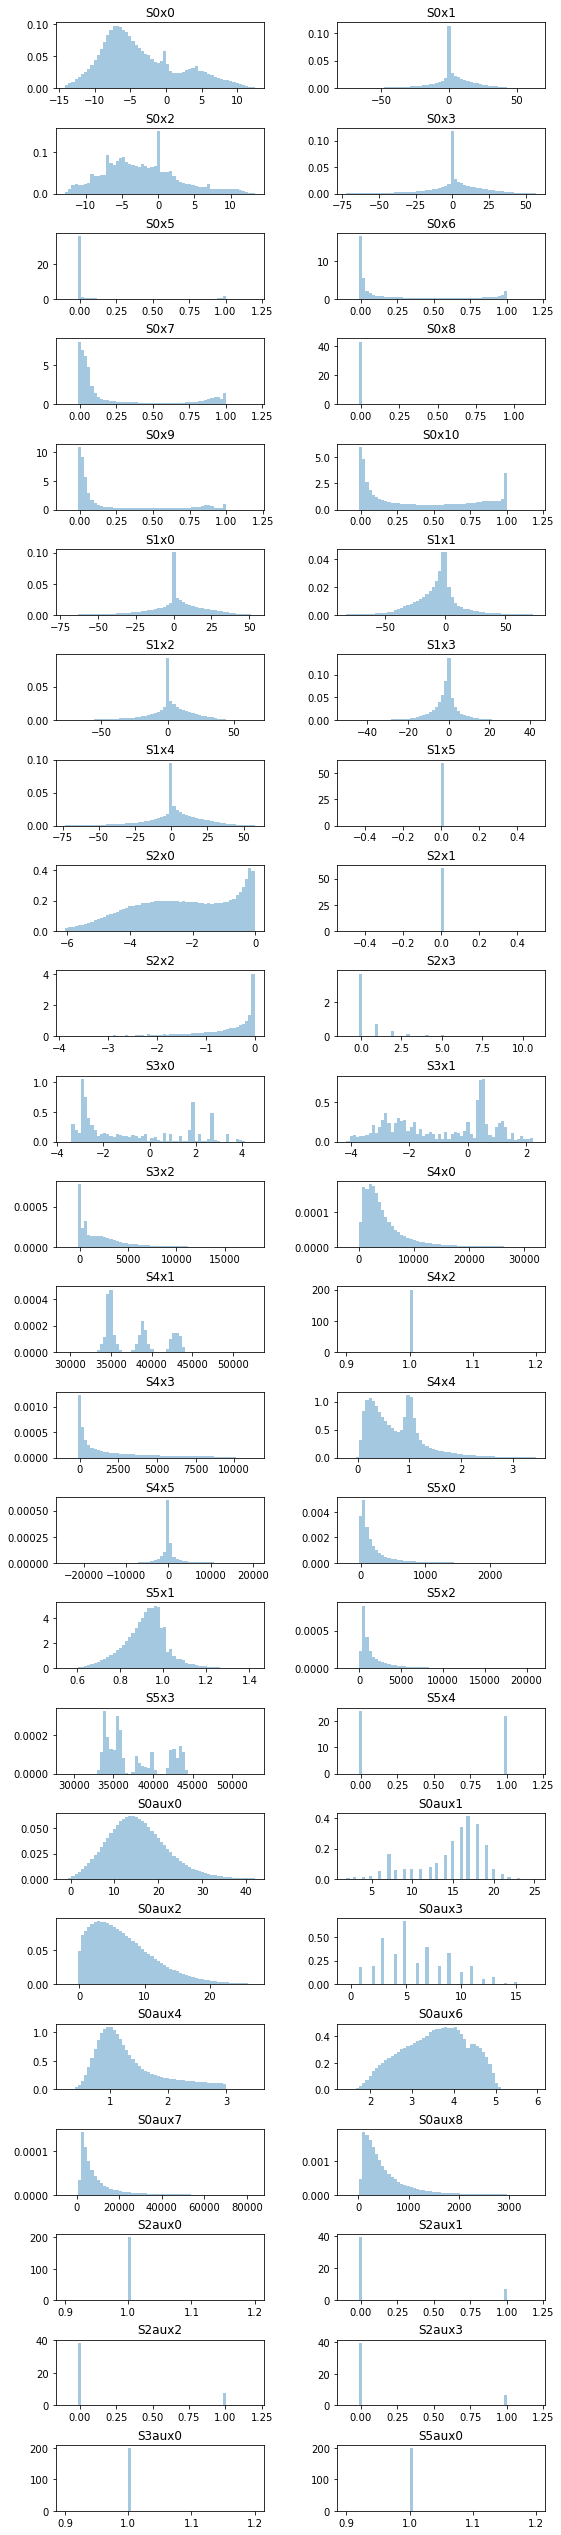

In [9]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

# Разобъем индексы на train и test

In [10]:
# train test split
train_size = 0.7
test_size = 0.3
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

In [11]:
df.shape, idx_train.shape, idx_test.shape

((3272304, 50), (2290612,), (981692,))

## Переведем значения признаков в отрезок $[-1, 1]$

Ранее помимо масштабирования признаков меняли и их распределение на равномерное, но это не имеет смысла, так как энкодер и декодер восстанавливают распределения $P(Z|X)$ и $Q(X|Z)$ соответственно. А по ним уже восстанавливается распределение $P(X)$ каким бы оно не было.

##### Так то оно правильно, но, может быть, автоэнкодеру проще восстановить равномерное распределение, чем произвольное?!

In [12]:
df_scaled = df.copy()

In [13]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    cur_idx_without_nan = pd.isnull(df[var]) ^ True
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].dropna().values.reshape(-1, 1))
    df_scaled[var][cur_idx_without_nan] = std_scaler.transform(
        df[var][cur_idx_without_nan].values.reshape(-1, 1)
    )
    
    # normalize with MaxAbsScaler
    max_scaler = MaxAbsScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].dropna().values.reshape(-1, 1))
    df_scaled[var][cur_idx_without_nan] = max_scaler.transform(
        df_scaled[var][cur_idx_without_nan].values.reshape(-1, 1)
    )
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CPU times: user 40.9 s, sys: 2.43 s, total: 43.4 s
Wall time: 43.1 s


CPU times: user 23.3 s, sys: 9.14 s, total: 32.4 s
Wall time: 24.4 s


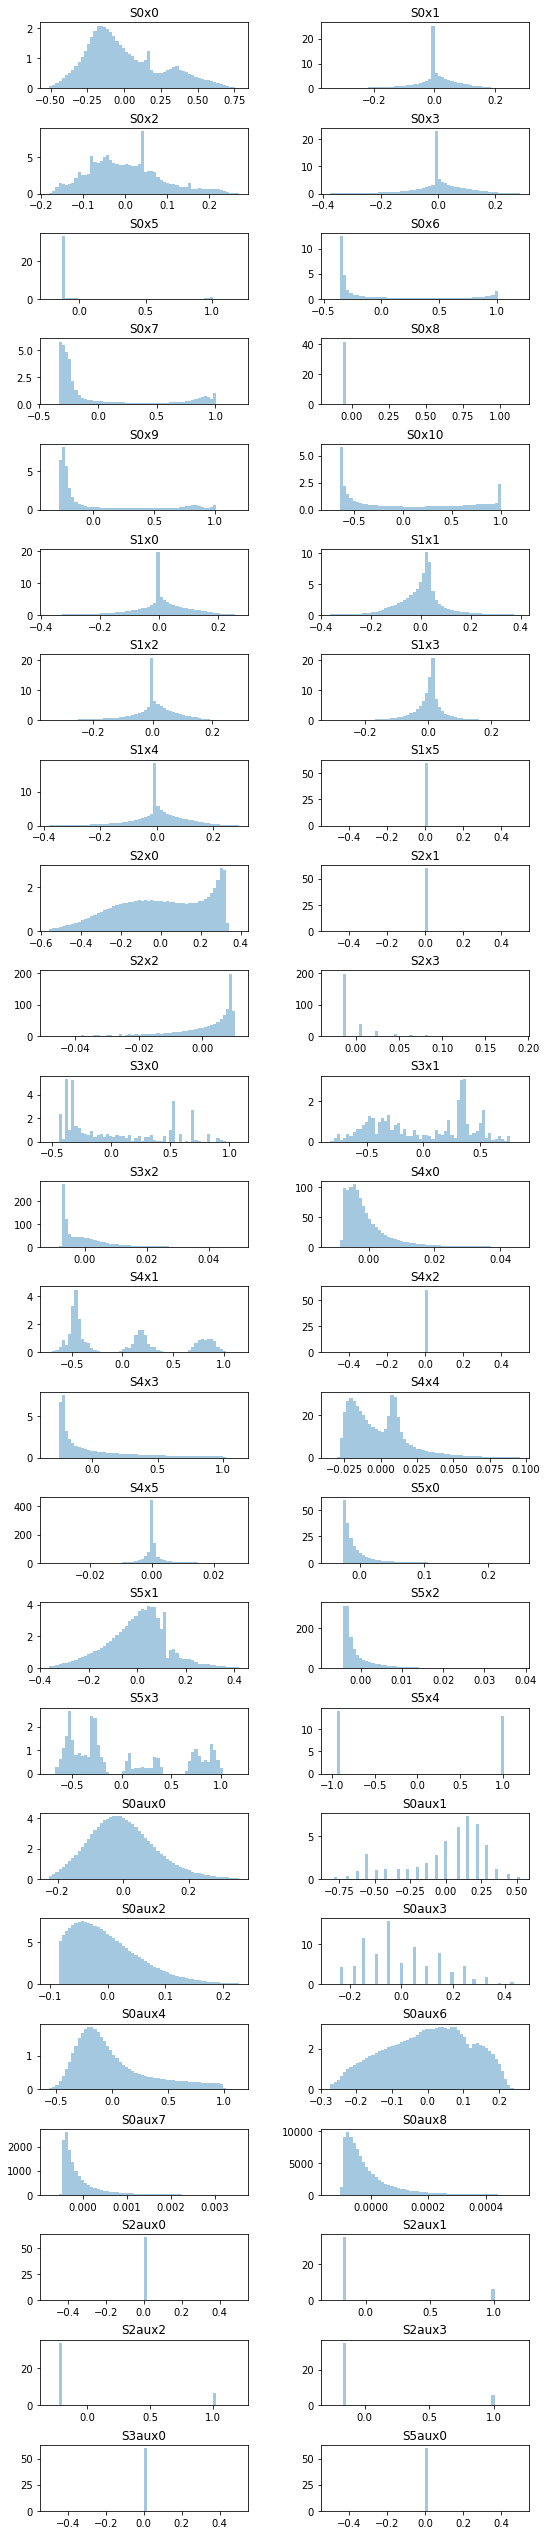

In [14]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")

### Сгруппируем детекторы

In [15]:
detectors_groups_dict = OrderedDict({
    'S' + str(i): [var for var in vars_list_input if var[1] == str(i)] for i in range(6)
})
detectors_groups_dict.update({
    'S' + str(i) + 'aux': [var for var in vars_list_aux if var[1] == str(i)] for i in [0, 2, 3, 5]
})

In [16]:
detectors_groups_dict

OrderedDict([('S0',
              ['S0x0',
               'S0x1',
               'S0x2',
               'S0x3',
               'S0x5',
               'S0x6',
               'S0x7',
               'S0x8',
               'S0x9',
               'S0x10']),
             ('S1', ['S1x0', 'S1x1', 'S1x2', 'S1x3', 'S1x4', 'S1x5']),
             ('S2', ['S2x0', 'S2x1', 'S2x2', 'S2x3']),
             ('S3', ['S3x0', 'S3x1', 'S3x2']),
             ('S4', ['S4x0', 'S4x1', 'S4x2', 'S4x3', 'S4x4', 'S4x5']),
             ('S5', ['S5x0', 'S5x1', 'S5x2', 'S5x3', 'S5x4']),
             ('S0aux',
              ['S0aux0',
               'S0aux1',
               'S0aux2',
               'S0aux3',
               'S0aux4',
               'S0aux6',
               'S0aux7',
               'S0aux8']),
             ('S2aux', ['S2aux0', 'S2aux1', 'S2aux2', 'S2aux3']),
             ('S3aux', ['S3aux0']),
             ('S5aux', ['S5aux0'])])

In [17]:
detectors_groups_dict.values()

odict_values([['S0x0', 'S0x1', 'S0x2', 'S0x3', 'S0x5', 'S0x6', 'S0x7', 'S0x8', 'S0x9', 'S0x10'], ['S1x0', 'S1x1', 'S1x2', 'S1x3', 'S1x4', 'S1x5'], ['S2x0', 'S2x1', 'S2x2', 'S2x3'], ['S3x0', 'S3x1', 'S3x2'], ['S4x0', 'S4x1', 'S4x2', 'S4x3', 'S4x4', 'S4x5'], ['S5x0', 'S5x1', 'S5x2', 'S5x3', 'S5x4'], ['S0aux0', 'S0aux1', 'S0aux2', 'S0aux3', 'S0aux4', 'S0aux6', 'S0aux7', 'S0aux8'], ['S2aux0', 'S2aux1', 'S2aux2', 'S2aux3'], ['S3aux0'], ['S5aux0']])

## Зададим архитектуру автоэнкодера

In [18]:
def create_autoencoder_aux(n_features, encoding_dim, n_aux_features=5, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
        x = keras.layers.concatenate([x, aux_inputs])

#     x = Dropout(p_drop)(x)
    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    x = keras.layers.concatenate([x, aux_inputs])
#     x = Dropout(p_drop)(x)
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = Dropout(p_drop)(x)
    
    for i in range(n_layers - 1):
        x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
#     x = Dropout(p_drop)(x)
    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )

    optimizer_adam = Adam(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

In [19]:
def penalized_loss(mask):
    def loss(y_true, y_pred):
        return K.mean(tf.boolean_mask(K.square(y_pred - y_true), mask), axis=-1)
    return loss


def create_autoencoder_full_data_aux(n_features, n_compressed_features, detectors_groups_dict, encoding_dim,
                                     p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs_dict = OrderedDict({
        group: Input(shape=(len(features), ), name=group)
        for group, features in detectors_groups_dict.items() if 'aux' not in group
    })
    aux_inputs_dict = OrderedDict({
        group: Input(shape=(len(features), ), name=group)
        for group, features in detectors_groups_dict.items() if 'aux' in group
    })
    mask = Input(shape=(n_compressed_features, ), name='mask', dtype=bool)
    
    encoder_input = keras.layers.concatenate(
        [inpt for inpt in inputs_dict.values()] + [inpt for inpt in aux_inputs_dict.values()]
    )
    
    # None -> 0
#     encoder_input[mask ^ True] = 0
    x = encoder_input

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
#         x = keras.layers.concatenate([x, aux_inputs])

#     x = Dropout(p_drop)(x)
    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = keras.layers.concatenate([x, aux_inputs])
#     x = Dropout(p_drop)(x)
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded] + [inpt for inpt in aux_inputs_dict.values()])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = Dropout(p_drop)(x)
    
    for i in range(n_layers - 1):
#         x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
#     x = Dropout(p_drop)(x)
    decoded = Dense(n_compressed_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model(
        [inpt for inpt in inputs_dict.values()] + [inpt for inpt in aux_inputs_dict.values()] + [mask], 
        encoded, name="encoder")
    decoder = Model([input_encoded] + [inpt for inpt in aux_inputs_dict.values()], decoded, name="decoder")
    autoencoder = Model(
        [inpt for inpt in inputs_dict.values()] + [inpt for inpt in aux_inputs_dict.values()] + [mask], 
        decoder(
            [encoder(
                [inpt for inpt in inputs_dict.values()] + [inpt for inpt in aux_inputs_dict.values()] + [mask]
             )] + [inpt for inpt in aux_inputs_dict.values()]), name="autoencoder"
    )

    optimizer_adam = Adam(lr=0.001)
#     loss = K.sum(K.square(autoencoder.output - encoder_input)[mask], axis=-1)
    autoencoder.compile(loss=penalized_loss(mask), optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Обучим автоэнкодер

In [ ]:
l_encoding_dim = [1, 3, 6, 9, 12, 15, 18]
l_score = []
n_features = sum(len(features) for features in detectors_groups_dict.values())
n_compressed_features = sum(len(features) for group, features in detectors_groups_dict.items() 
                            if 'aux' not in group)
val_size = 0.1

train = df_scaled.fillna(value=0).iloc[idx_train]
test = df_scaled.fillna(value=0).iloc[idx_test]

train_input = OrderedDict({
    group: train[features].values
    for group, features in detectors_groups_dict.items() if 'aux' not in group
})
train_aux   = OrderedDict({
    group: train[features].values
    for group, features in detectors_groups_dict.items() if 'aux' in group
})
train_MC    = train[vars_list_MC].values
train_mask  = np.concatenate(df['mask'].iloc[idx_train].values).reshape((-1, n_compressed_features))

test_input = OrderedDict({
    group: test[features].values
    for group, features in detectors_groups_dict.items() if 'aux' not in group
})
test_aux   = OrderedDict({
    group: test[features].values
    for group, features in detectors_groups_dict.items() if 'aux' in group
})
test_MC    = test[vars_list_MC].values
test_mask  = np.concatenate(df['mask'].iloc[idx_test].values).reshape((-1, n_compressed_features))

In [ ]:
nb_epoch = 30
batch_size = 128
n_layers = 4
thickness = 6

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}

In [ ]:
n_repeats_autoencoder = np.ones_like(l_encoding_dim, dtype=int)
n_evals_for_autoencoder = np.zeros_like(l_encoding_dim, dtype=int)

In [ ]:
%%time
while np.sum(n_repeats_autoencoder - n_evals_for_autoencoder) > 0:
    for i, encoding_dim in tqdm(enumerate(clf_encoding_dim)):
        if n_evals_for_dim[i] >= n_repeats[i]:
            continue
        
        print("encoding_dim : ", encoding_dim)
        autoencoder, encoder, decoder = create_autoencoder_full_data_aux(
            n_features, n_compressed_features, detectors_groups_dict, encoding_dim, n_layers=3, thickness=2
        )

        # Fit model
        start_time = timeit.default_timer()
        history = autoencoder.fit(
            [inpt for inpt in train_input.values()] + [inpt for inpt in train_aux.values()] + [train_mask],
            np.concatenate([inpt for inpt in train_input.values()], axis=1),
            epochs=nb_epoch, batch_size=batch_size,
            shuffle=True, verbose=1,
            validation_split=val_size, callbacks = [early_stopping, tensorboard]
        )
        
        # Predict
        score = autoencoder.evaluate(
            [inpt for inpt in test_input.values()] + [inpt for inpt in test_aux.values()] + [test_mask],
            np.concatenate([inpt for inpt in test_input.values()], axis=1), batch_size=batch_size
        )
        encoded_test = encoder.predict(
            [inpt for inpt in test_input.values()] + [inpt for inpt in test_aux.values()] + [test_mask]
        )
        decoded_test = decoder.predict([encoded_test] + [inpt for inpt in test_aux.values()]) # test mode = 0
        run_time = timeit.default_timer() - start_time

        # Save
        save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
        save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)
        l_score.append(score)
        n_evals_for_dim[i] += 1

        # Plot
        print("Run time: {:.2f} sec".format(run_time))
        print('n_evals_for_dim: ', n_evals_for_dim)
        plt.plot(history.history['loss'], "b")
        plt.plot(history.history['val_loss'], "r")
        plt.show()
        print("\n\n")

  0%|          | 0/7 [00:00<?, ?it/s]

encoding_dim :  1


/opt/conda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2061550 samples, validate on 229062 samples
Epoch 1/30
2061550/2061550 [==============================] - 181s 88us/step - loss: 0.0335 - val_loss: 0.0268
Epoch 2/30
2061550/2061550 [==============================] - 182s 88us/step - loss: 0.0255 - val_loss: 0.0246
Epoch 3/30
2061550/2061550 [==============================] - 179s 87us/step - loss: 0.0233 - val_loss: 0.0221
Epoch 4/30
2061550/2061550 [==============================] - 180s 88us/step - loss: 0.0215 - val_loss: 0.0211
Epoch 5/30
2061550/2061550 [==============================] - 183s 89us/step - loss: 0.0204 - val_loss: 0.0199
Epoch 6/30
2061550/2061550 [==============================] - 183s 89us/step - loss: 0.0198 - val_loss: 0.0196
Epoch 7/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0192 - val_loss: 0.0188
Epoch 8/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0186 - val_loss: 0.0184
Epoch 9/30
2061550/2061550 [==============================]

 14%|█▍        | 1/7 [1:00:22<6:02:15, 3622.65s/it]




encoding_dim :  3
Train on 2061550 samples, validate on 229062 samples
Epoch 1/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 0.0131 - val_loss: 0.0090
Epoch 2/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0080 - val_loss: 0.0076
Epoch 3/30
2061550/2061550 [==============================] - 183s 89us/step - loss: 0.0070 - val_loss: 0.0066
Epoch 4/30
2061550/2061550 [==============================] - 183s 89us/step - loss: 0.0061 - val_loss: 0.0058
Epoch 5/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0055 - val_loss: 0.0053
Epoch 6/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0050 - val_loss: 0.0049
Epoch 7/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/30
2061550/2061550 [==========

 29%|██▊       | 2/7 [2:23:03<5:35:20, 4024.08s/it]




encoding_dim :  6
Train on 2061550 samples, validate on 229062 samples
Epoch 1/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0045 - val_loss: 0.0026
Epoch 2/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/30
2061550/2061550 [==========

 43%|████▎     | 3/7 [3:58:54<5:02:48, 4542.14s/it]




encoding_dim :  9
Train on 2061550 samples, validate on 229062 samples
Epoch 1/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 2/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 8.3789e-04 - val_loss: 7.5445e-04
Epoch 3/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 6.9607e-04 - val_loss: 6.4166e-04
Epoch 4/30
2061550/2061550 [==============================] - 185s 90us/step - loss: 6.3423e-04 - val_loss: 6.0438e-04
Epoch 5/30
2061550/2061550 [==============================] - 184s 89us/step - loss: 5.9773e-04 - val_loss: 6.0515e-04
Epoch 6/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 5.7322e-04 - val_loss: 5.6802e-04
Epoch 7/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 5.5331e-04 - val_loss: 5.6614e-04
Epoch 8/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 5.3539e-04 - val

 57%|█████▋    | 4/7 [5:21:59<3:53:45, 4675.18s/it]




encoding_dim :  12
Train on 2061550 samples, validate on 229062 samples
Epoch 1/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 0.0014 - val_loss: 6.9142e-04
Epoch 2/30
2061550/2061550 [==============================] - 193s 94us/step - loss: 6.2717e-04 - val_loss: 5.2506e-04
Epoch 3/30
2061550/2061550 [==============================] - 189s 91us/step - loss: 5.1414e-04 - val_loss: 4.1915e-04
Epoch 4/30
2061550/2061550 [==============================] - 186s 90us/step - loss: 3.8748e-04 - val_loss: 4.2665e-04
Epoch 5/30
2061550/2061550 [==============================] - 188s 91us/step - loss: 3.3494e-04 - val_loss: 3.0544e-04
Epoch 6/30
2061550/2061550 [==============================] - 193s 93us/step - loss: 3.0864e-04 - val_loss: 2.8642e-04
Epoch 7/30
2061550/2061550 [==============================] - 191s 93us/step - loss: 2.9507e-04 - val_loss: 2.6445e-04
Epoch 8/30
2061550/2061550 [==============================] - 190s 92us/step - loss: 2.7884e-04 

 71%|███████▏  | 5/7 [6:58:05<2:46:44, 5002.35s/it]




encoding_dim :  15
Train on 2061550 samples, validate on 229062 samples
Epoch 1/30
2061550/2061550 [==============================] - 187s 91us/step - loss: 8.3982e-04 - val_loss: 3.9197e-04
Epoch 2/30
2061550/2061550 [==============================] - 190s 92us/step - loss: 3.3510e-04 - val_loss: 2.9213e-04
Epoch 3/30
1484800/2061550 [====================>.........] - ETA: 49s - loss: 2.9466e-04

In [28]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
S0 (InputLayer)                 (None, 10)           0                                            
__________________________________________________________________________________________________
S1 (InputLayer)                 (None, 6)            0                                            
__________________________________________________________________________________________________
S2 (InputLayer)                 (None, 4)            0                                            
__________________________________________________________________________________________________
S3 (InputLayer)                 (None, 3)            0                                            
__________________________________________________________________________________________________
S4 (InputL

In [29]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
S0 (InputLayer)                 (None, 10)           0                                            
__________________________________________________________________________________________________
S1 (InputLayer)                 (None, 6)            0                                            
__________________________________________________________________________________________________
S2 (InputLayer)                 (None, 4)            0                                            
__________________________________________________________________________________________________
S3 (InputLayer)                 (None, 3)            0                                            
__________________________________________________________________________________________________
S4 (InputL

In [30]:
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
S0aux (InputLayer)              (None, 8)            0                                            
__________________________________________________________________________________________________
S2aux (InputLayer)              (None, 4)            0                                            
__________________________________________________________________________________________________
S3aux (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
S5aux (Inp

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

## Сохраненим score, сжимаемые переменные, test и decoded(после обратного масштабирования)

In [38]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict



train = df_scaled.iloc[idx_train]
test = df_scaled.iloc[idx_test]
# test = df_scaled.fillna(value=0).iloc[idx_test]

test_input = test[vars_list_input].values
test_aux = test[vars_list_aux].values


retain_dict['test_input'] = test_input
retain_dict['test_aux'] = test_aux
retain_dict['test_MC'] = test_MC
retain_dict['test_mask'] = test_mask
retain_dict['l_score'] = l_score
retain_dict['vars_list_input'] = vars_list_input

In [39]:
test_input_unslaced = test_input.copy()
test_aux_unslaced = test_aux.copy()

In [13]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    cur_idx_without_nan = pd.isnull(df[var]) ^ True
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].dropna().values.reshape(-1, 1))
    df_scaled[var][cur_idx_without_nan] = std_scaler.transform(
        df[var][cur_idx_without_nan].values.reshape(-1, 1)
    )
    
    # normalize with MaxAbsScaler
    max_scaler = MaxAbsScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].dropna().values.reshape(-1, 1))
    df_scaled[var][cur_idx_without_nan] = max_scaler.transform(
        df_scaled[var][cur_idx_without_nan].values.reshape(-1, 1)
    )
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CPU times: user 40.9 s, sys: 2.43 s, total: 43.4 s
Wall time: 43.1 s


In [42]:
# %%time
for i, var in enumerate(vars_list_input):
    cur_idx_without_nan = pd.isnull(test_input_unslaced[:, i]) ^ True
    test_input_unslaced[cur_idx_without_nan, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_input[cur_idx_without_nan, i].reshape(-1, 1))
    ).reshape(-1)
    
for i, var in enumerate(vars_list_aux):
    cur_idx_without_nan = pd.isnull(test_aux_unslaced[:, i]) ^ True
    test_aux_unslaced[cur_idx_without_nan, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_aux[cur_idx_without_nan, i].reshape(-1, 1))
    ).reshape(-1)

retain_dict['test_input_dec'] = test_input_unslaced
retain_dict['test_aux_dec'] = test_aux_unslaced

In [43]:
save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        cur_idx_without_nan = pd.isnull(tmp_decoded_unscaled[:, i]) ^ True
        tmp_decoded_unscaled[cur_idx_without_nan, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[cur_idx_without_nan, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [44]:
pickle.dump(retain_dict, open("retain_dict_{}.p".format(TYPE), "wb"))

In [45]:
retain_dict.keys()

dict_keys(['save_decoded_dict', 'save_encoded_dict', 'test_input', 'test_aux', 'test_MC', 'test_mask', 'l_score', 'vars_list_input', 'test_input_dec', 'test_aux_dec', 'save_decoded_dict_dec'])

## Посмотрим на результаты работы автоэнкодеров

Загрузка сохраненных данных

In [46]:
# Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

pids = ['a', 'b', 'c', 'd', 'e']

retain_dict = pickle.load( open( "retain_dict_{}.p".format(TYPE), "rb" ) )
test_input = retain_dict.pop("test_input")
test_input_dec = retain_dict.pop("test_input_dec")
test_aux = retain_dict.pop("test_aux")
test_MC = retain_dict.pop("test_MC")
test_mask = retain_dict.pop("test_mask")
l_score = retain_dict.pop("l_score")
save_decoded_dict = retain_dict.pop("save_decoded_dict")
save_decoded_dict_dec = retain_dict.pop("save_decoded_dict_dec")
vars_list_input = retain_dict.pop("vars_list_input")

l_encoding_dim = list(save_decoded_dict.keys())

Распределение ошибки предсказаний автоэнкодера

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CPU times: user 1min 57s, sys: 28.3 s, total: 2min 25s
Wall time: 1min 54s


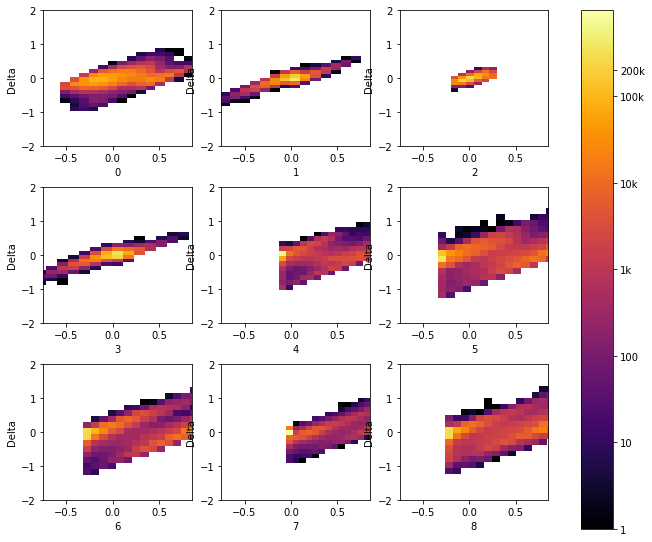

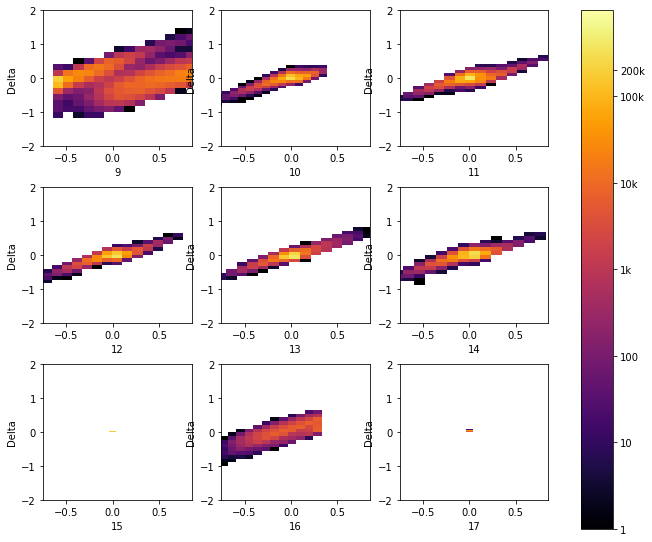

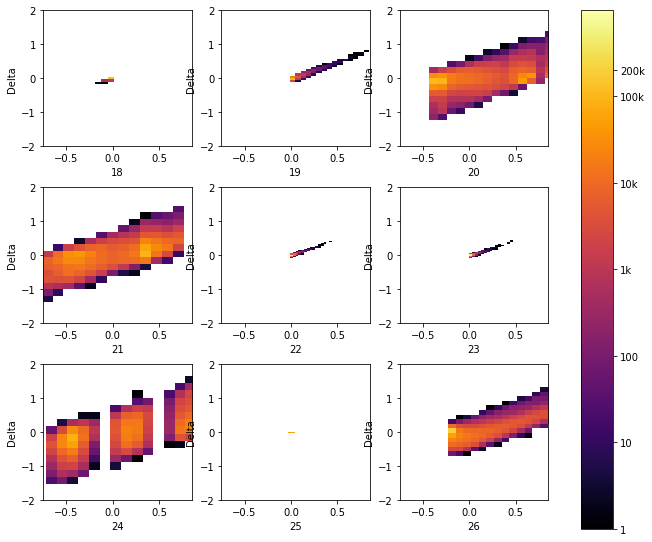

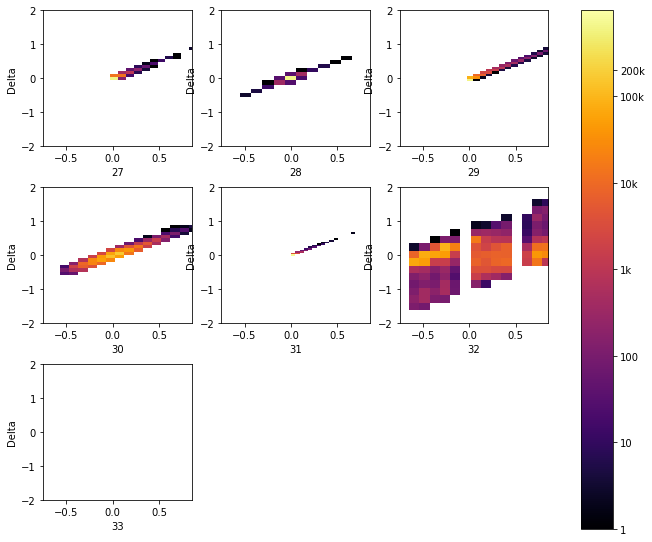

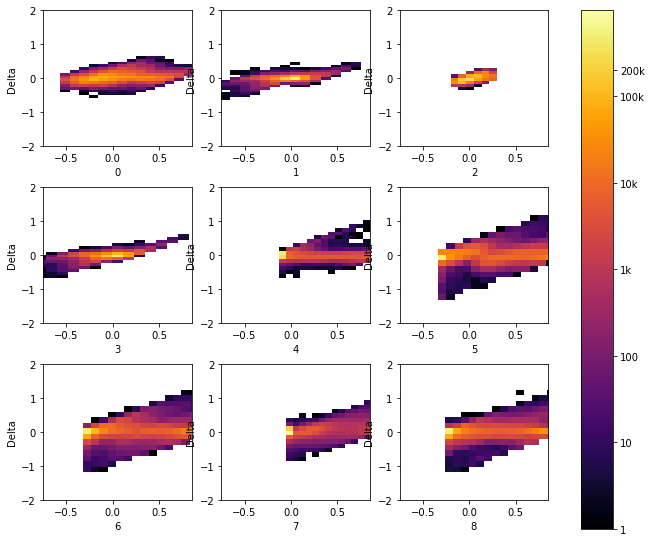

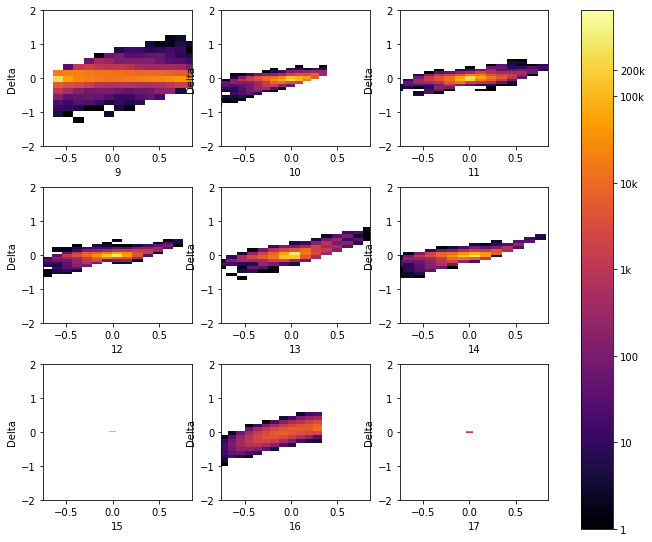

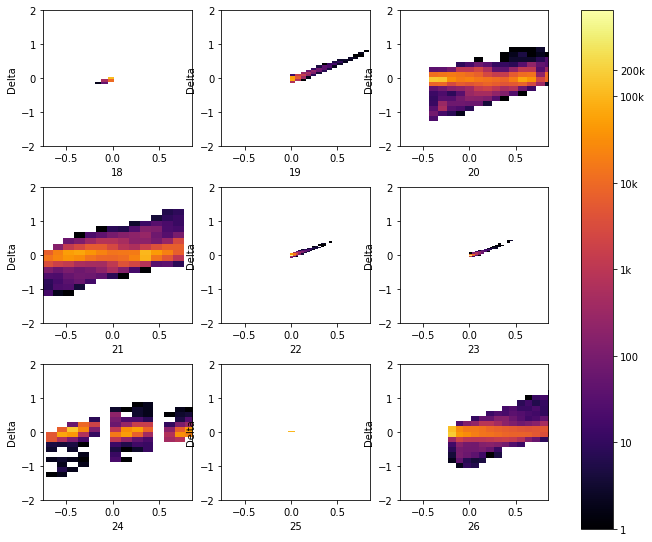

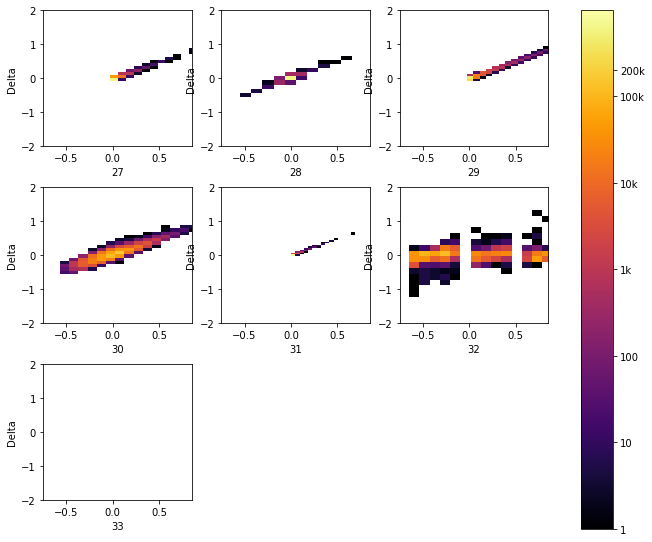

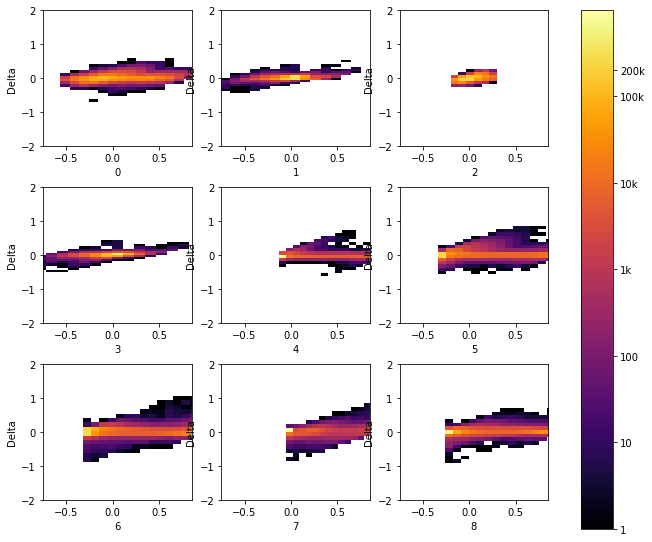

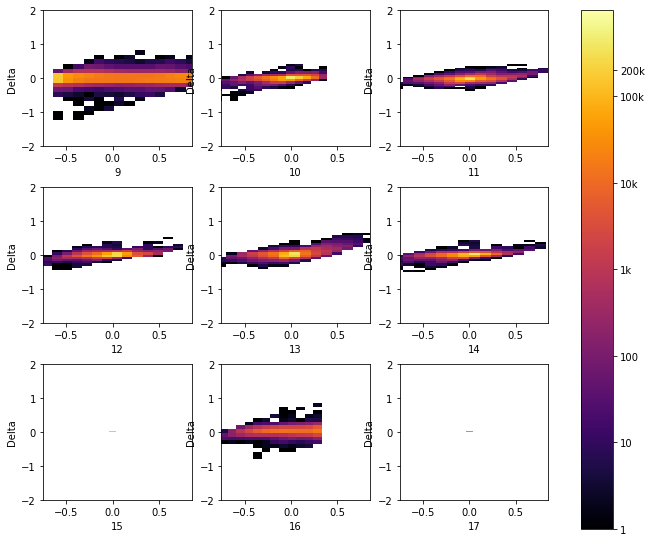

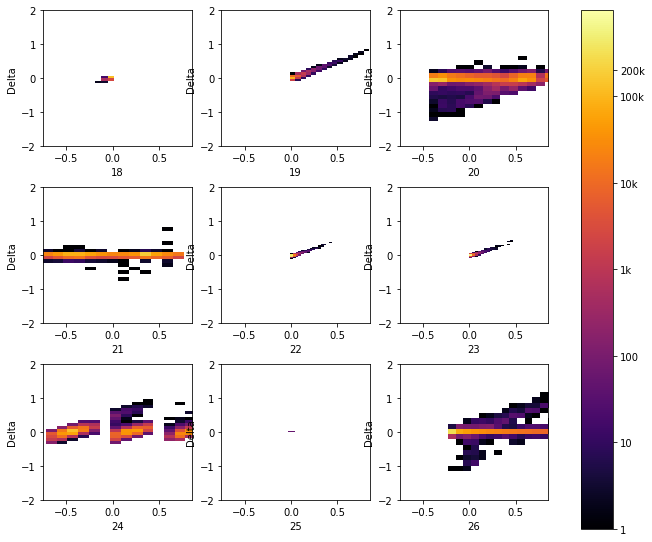

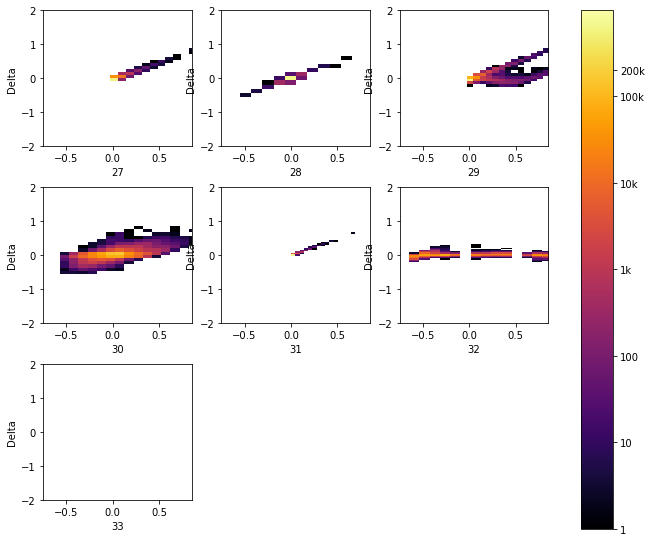

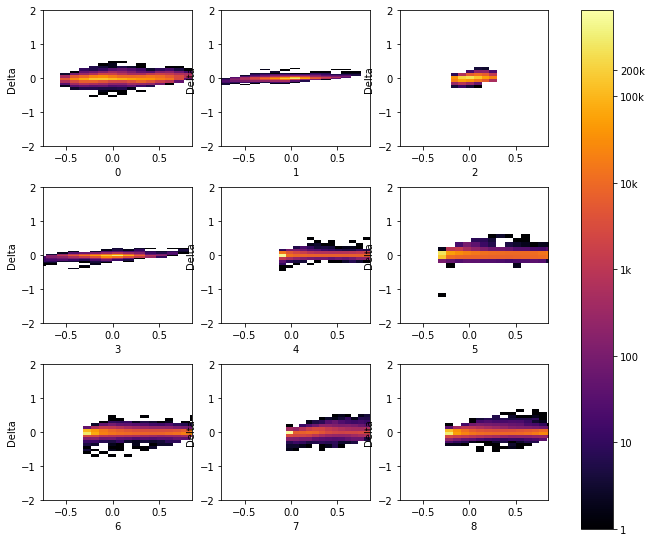

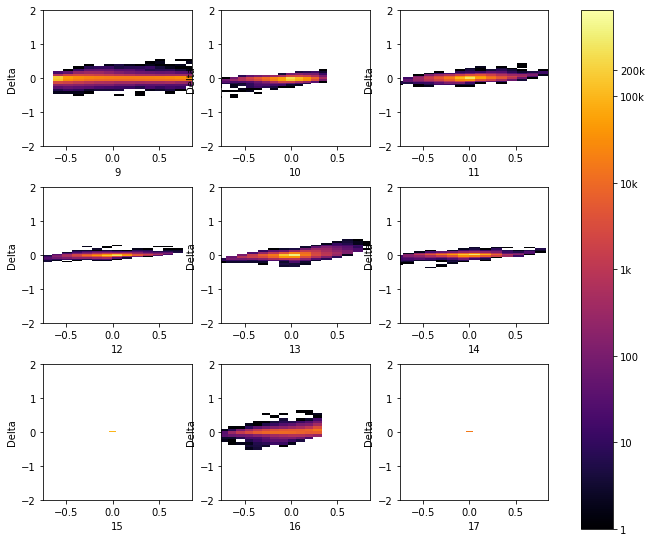

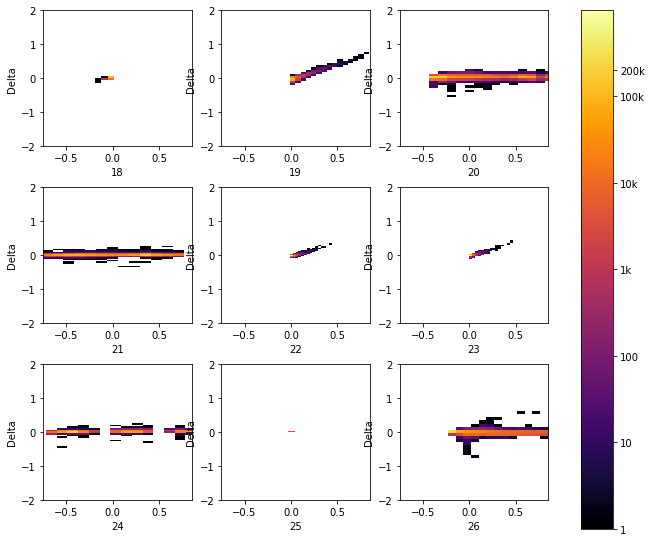

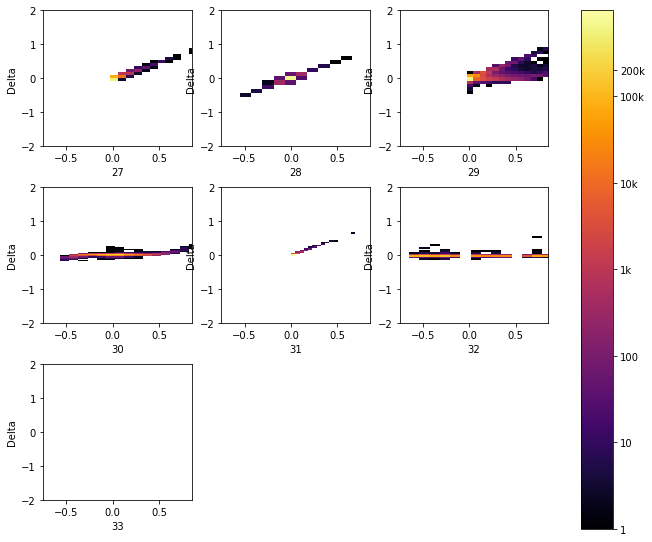

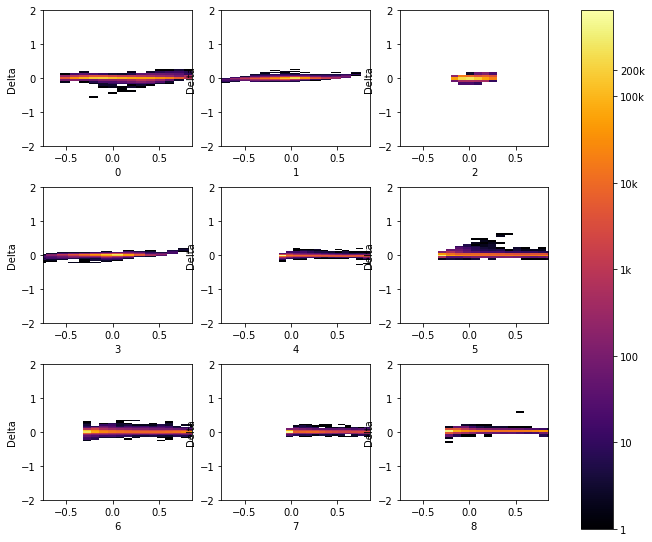

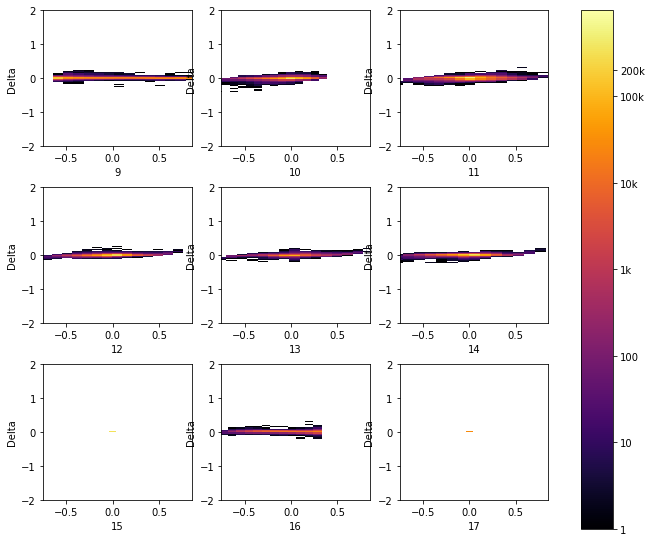

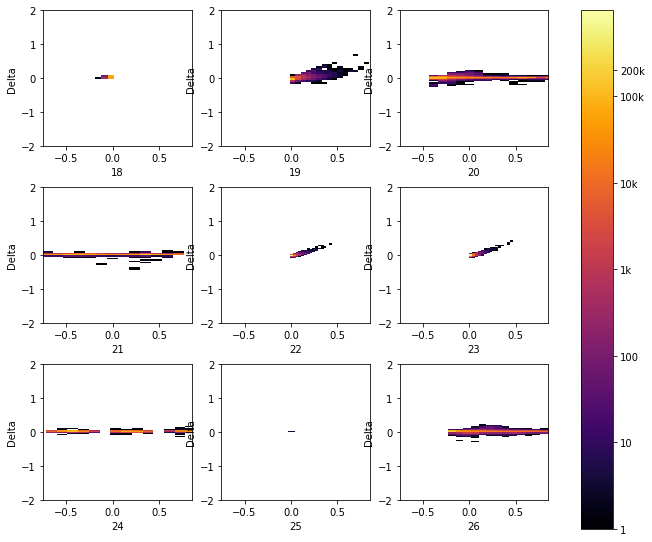

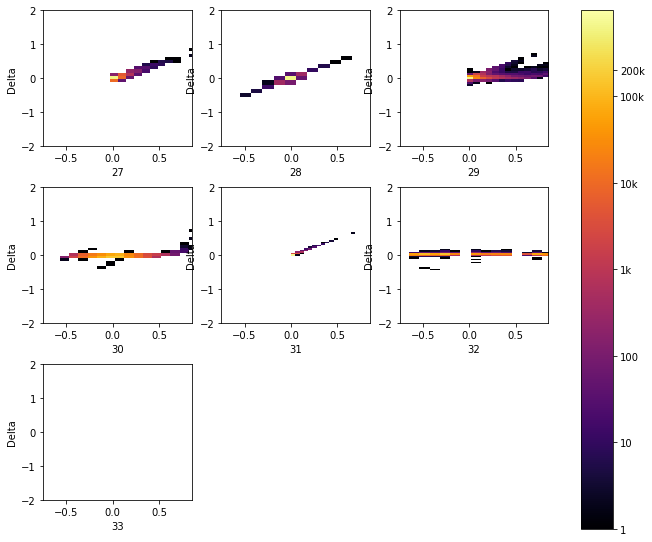

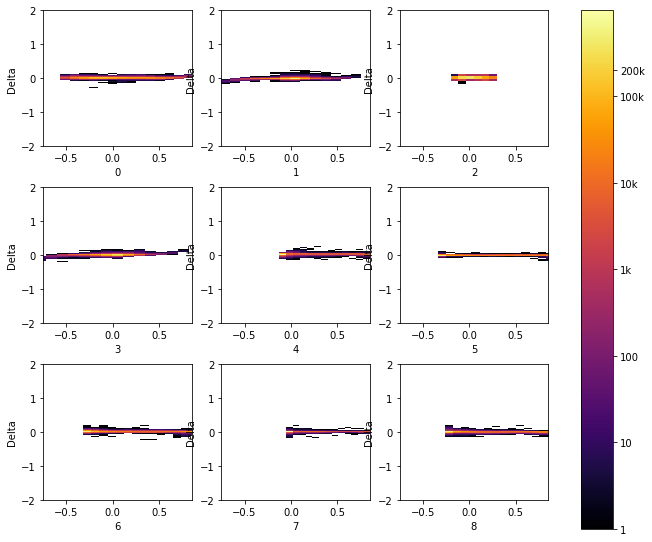

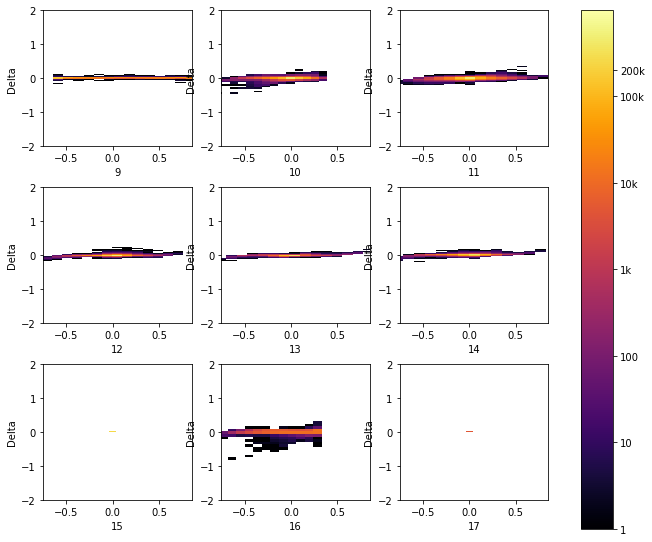

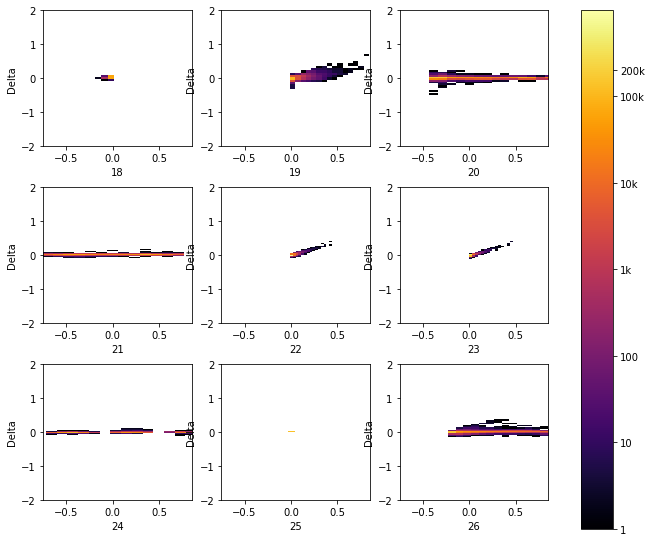

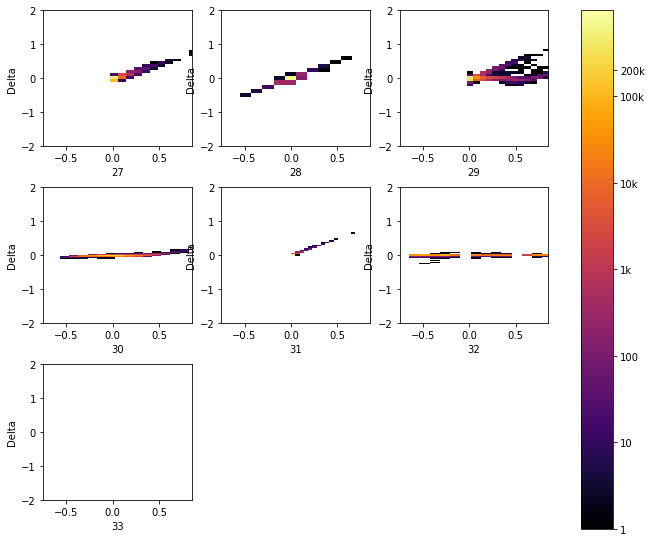

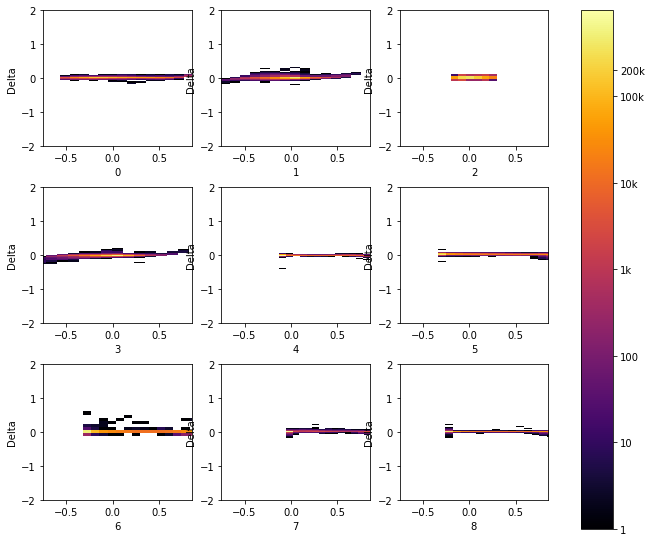

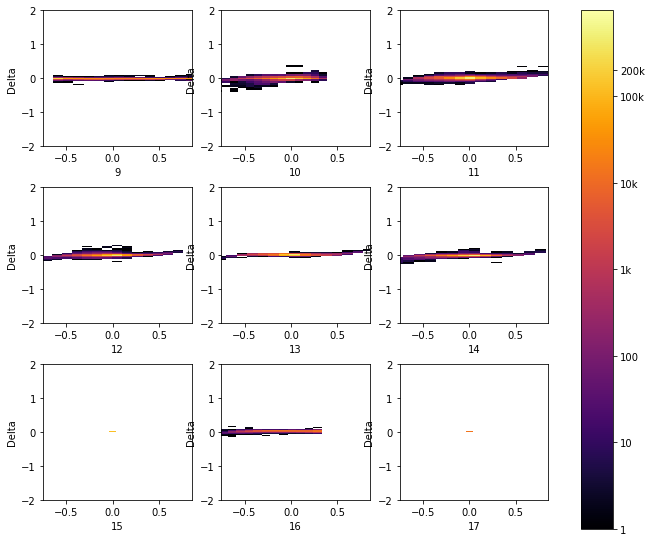

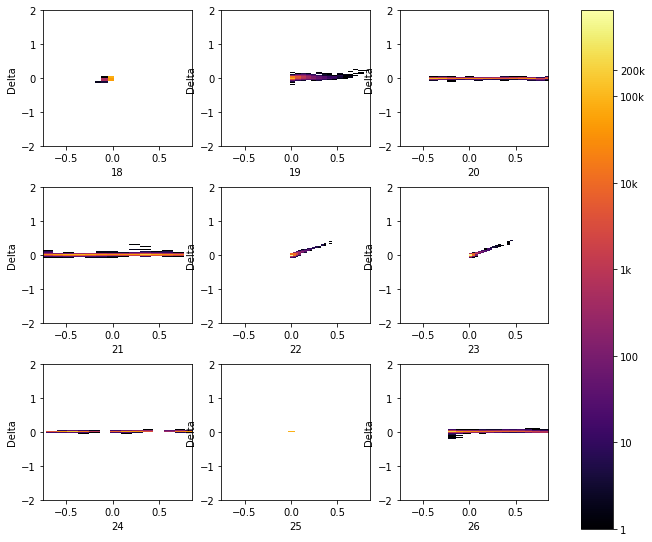

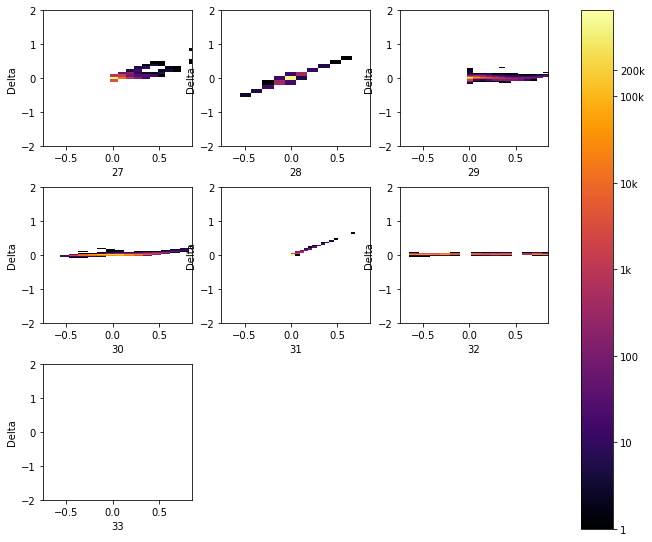

In [89]:
%%time
# The plots below show the difference between predictions to true scaled feature values 
# as a function of the true feature value. The closer the histograms are centered
# around the line y=0, the better the autoencoder has performed

l_minmax = [[-2, 2]] * n_compressed_features # The y limits
for encoding_dim in save_decoded_dict:
#for encoding_dim in [1]:
    plot_difference_displ(
        TYPE, pd.DataFrame(save_decoded_dict[encoding_dim]), pd.DataFrame(test_input), 
        encoding_dim, Transform=False, SetMinMax=True, FTS_SCLD=True, l_minmax=l_minmax, save_dir="img",
        save_filename="FeatureDeviation_{}_{}.png".format(encoding_dim, TYPE)
    )

Распределения значений фич до и после автоэнкодера

In [91]:
import sys, importlib
importlib.reload(sys.modules['Autoencoder_Utils'])

<module 'Autoencoder_Utils' from '/mnt/mivakhnenko/LHCb_PID_Compression/Autoencoder_Utils.py'>

******************** 1 ********************


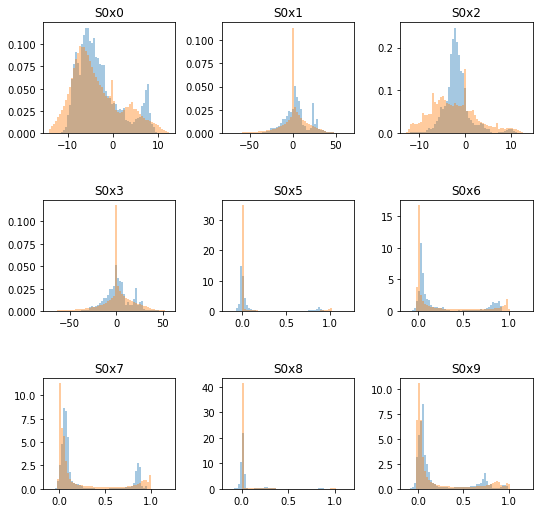

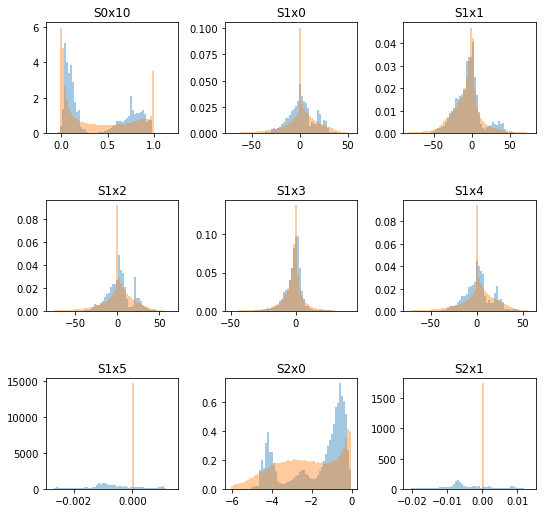

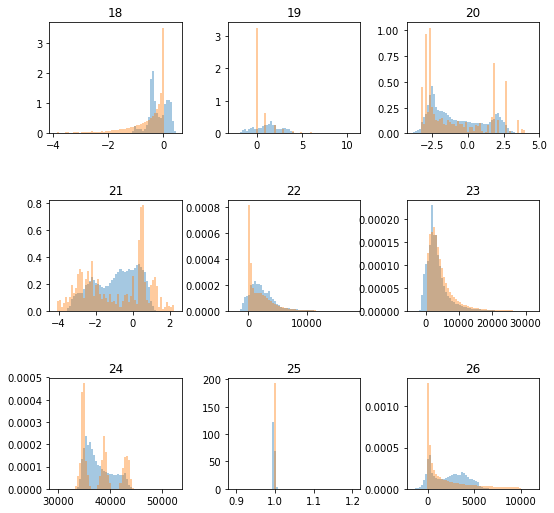

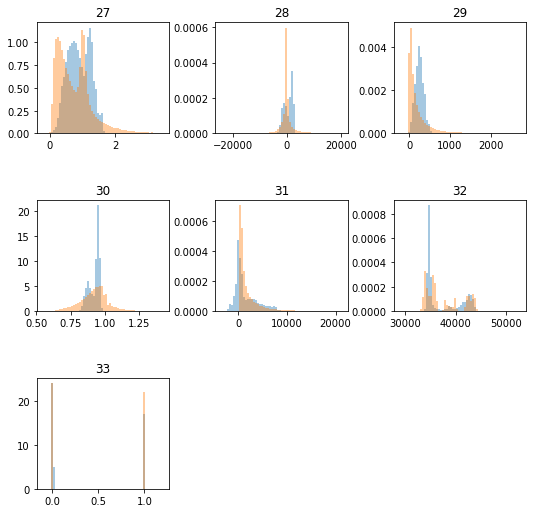

******************** 3 ********************


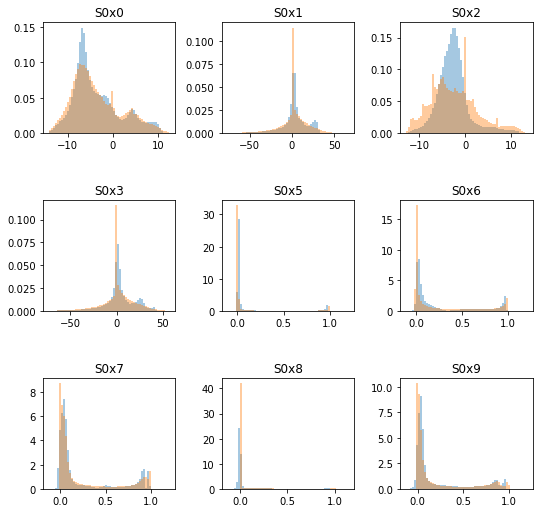

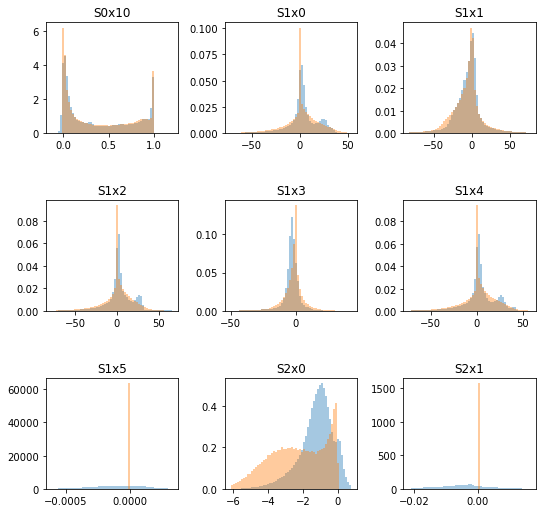

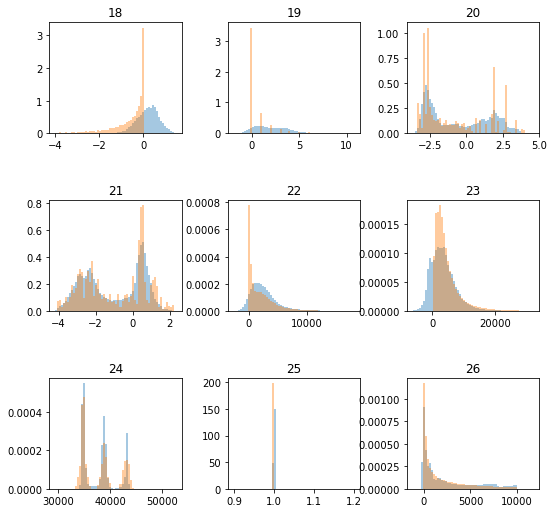

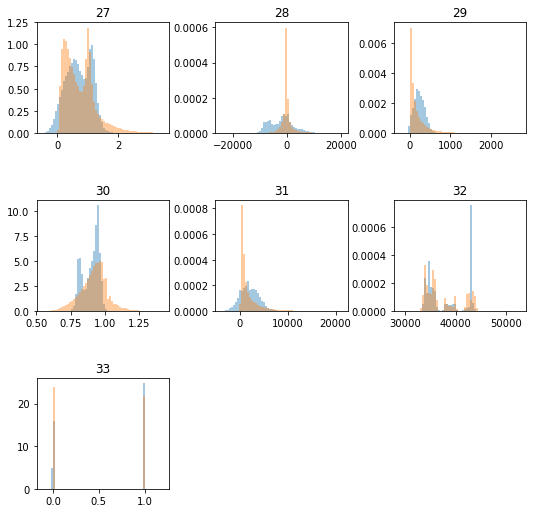

******************** 6 ********************


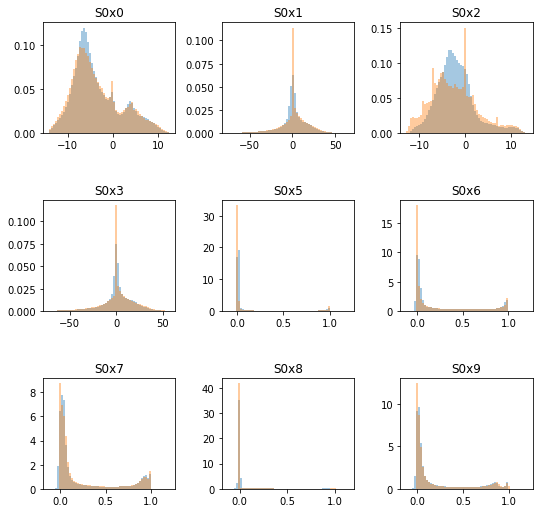

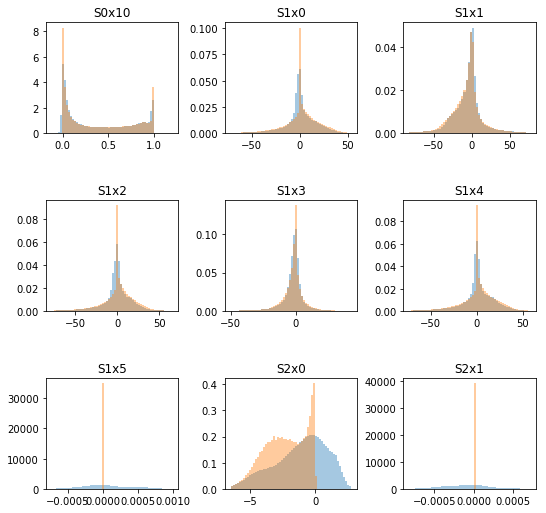

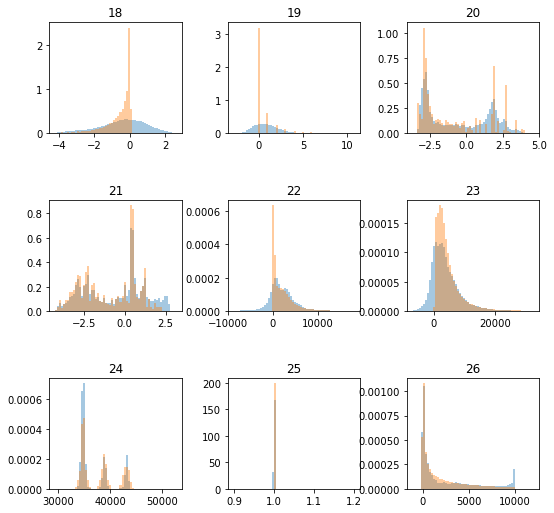

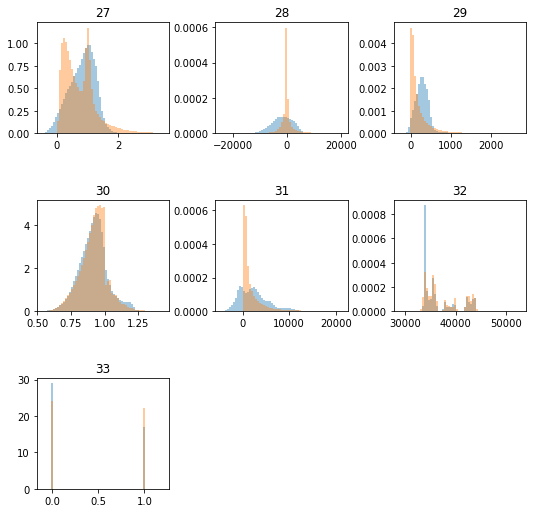

******************** 9 ********************


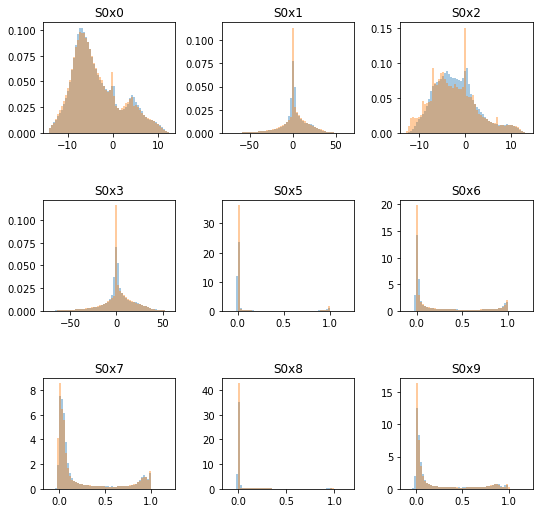

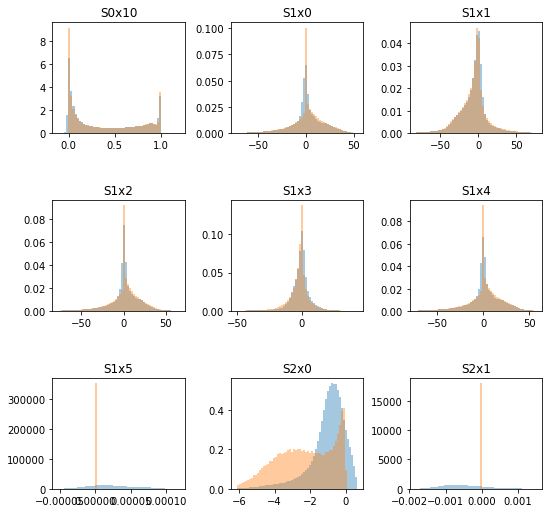

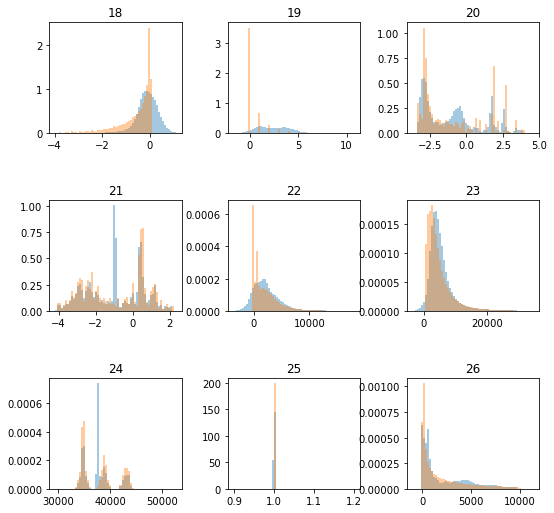

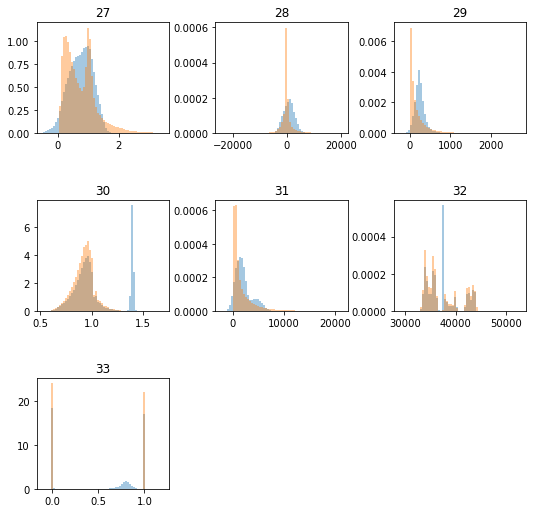

******************** 12 ********************


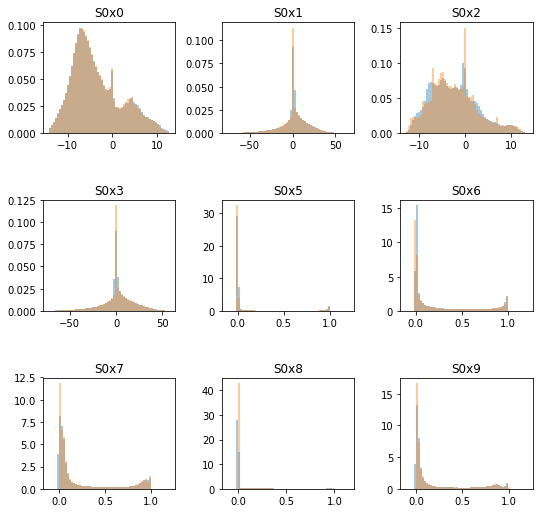

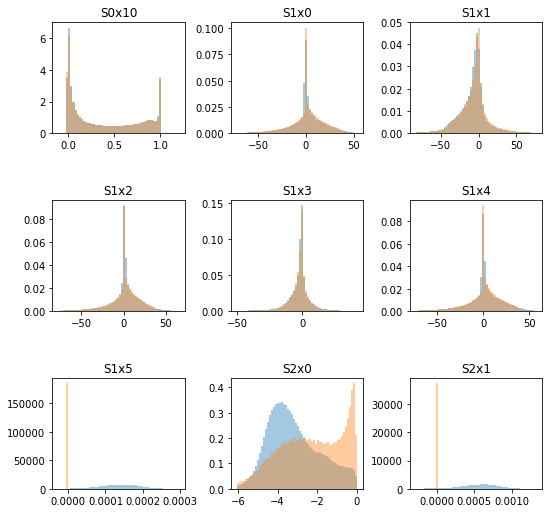

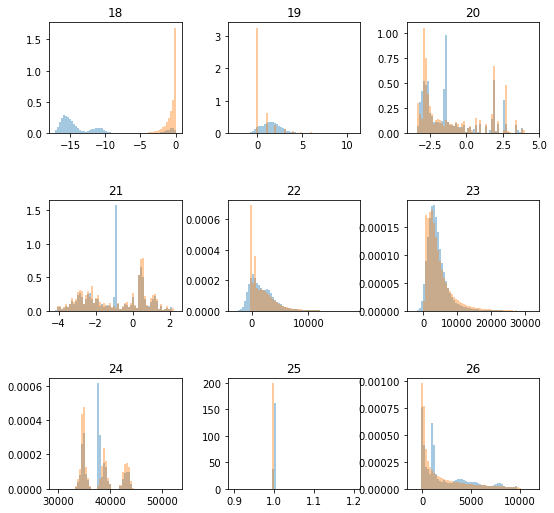

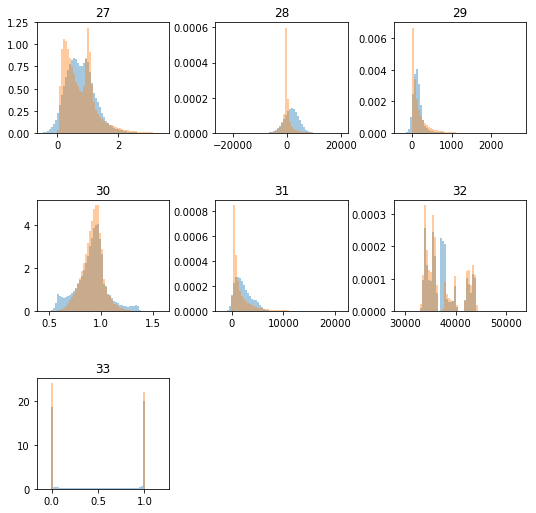

******************** 15 ********************


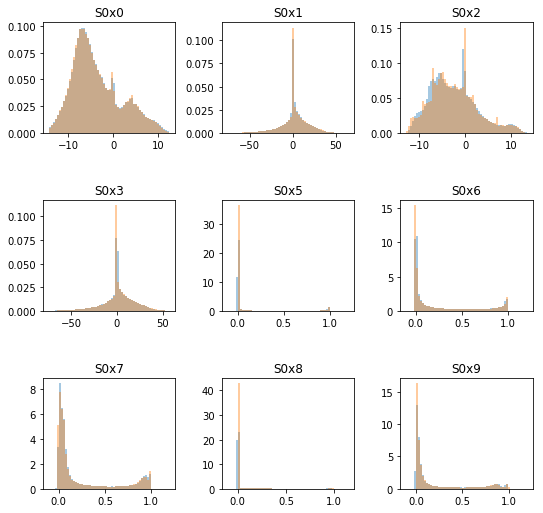

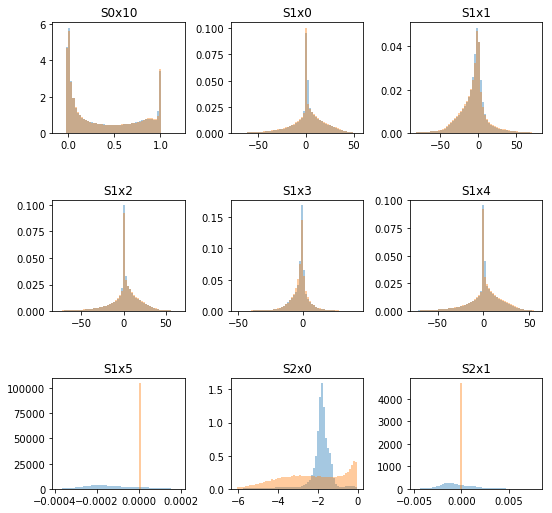

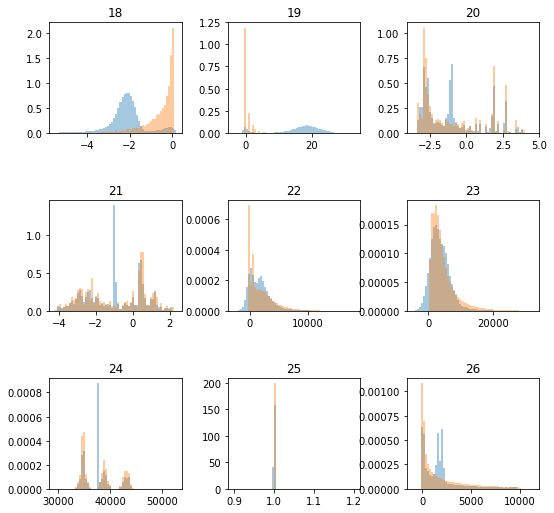

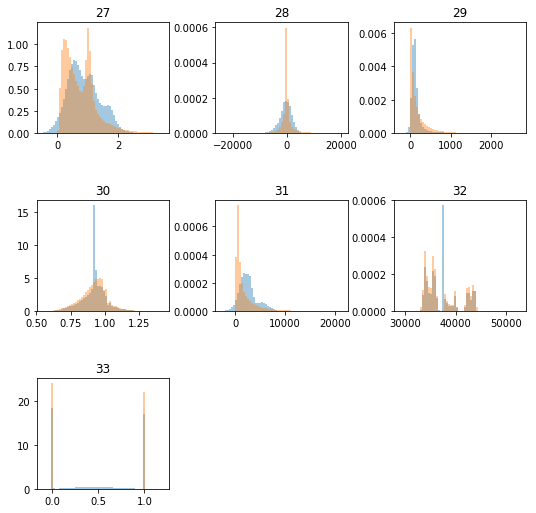

******************** 18 ********************


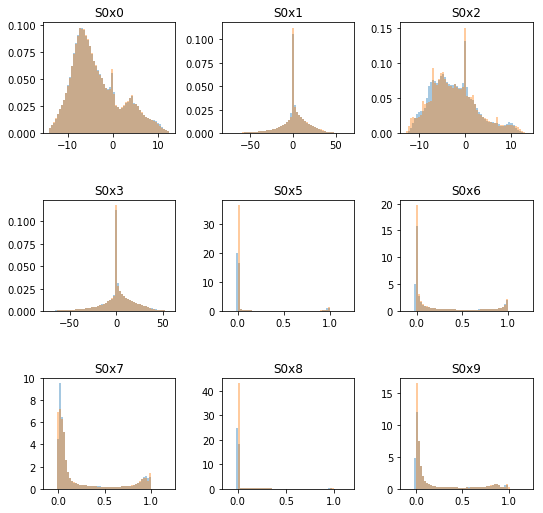

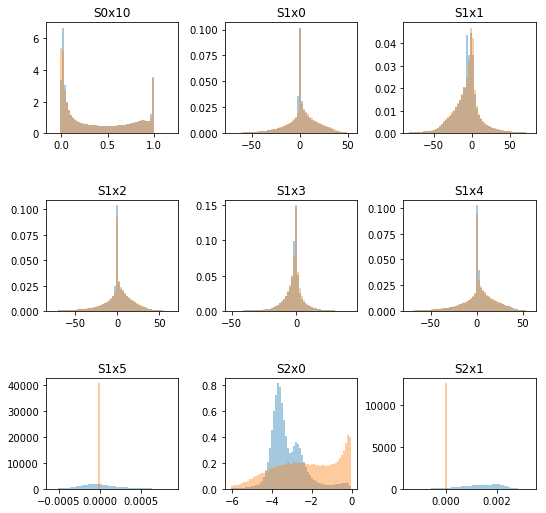

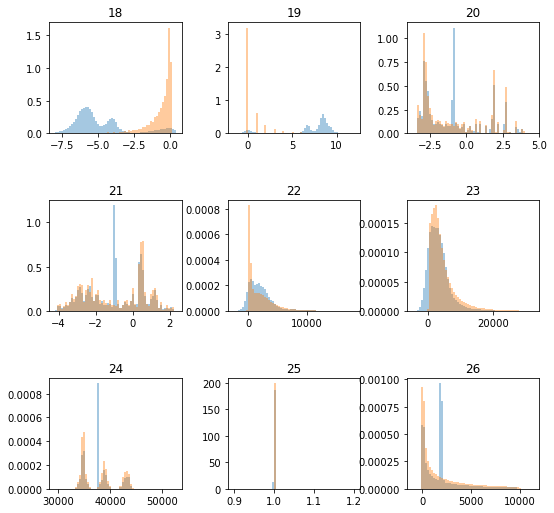

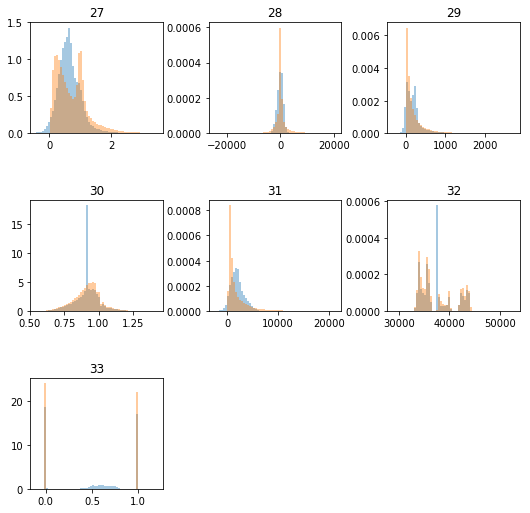

In [92]:
# The following plots show the orignal distributions in orange and the decoded distributions in blue.
# If the autoencoder has not lost a lot of information, these should lie on top of each other

rename_dict = {}
for i, e in enumerate(range(18)):
    rename_dict[e] = vars_list_input[i]
    
    
for encoding_dim in save_decoded_dict:
    # if you don't care about the names of the features uncomment the following line
#     print_features_histograms(
#         pd.DataFrame(save_decoded_dict_dec[encoding_dim]), 
#         target=pd.DataFrame(test_input_dec)
#     )
    print('*' * 20, encoding_dim, '*' * 20)
    
    df_temp = pd.DataFrame(save_decoded_dict_dec[encoding_dim])
    df_temp_input = pd.DataFrame(test_input_dec)

    df_temp.rename(columns=rename_dict, inplace=True)
    df_temp_input.rename(columns=rename_dict, inplace=True)

    print_features_histograms_displ(
        df_temp, target=df_temp_input, save_dir="img",
        save_filename="_{1}_orig_uncom_distribs_{0}.png".format(TYPE, encoding_dim)
    )
    plt.show()

Зависимость MSE от encoding_dim

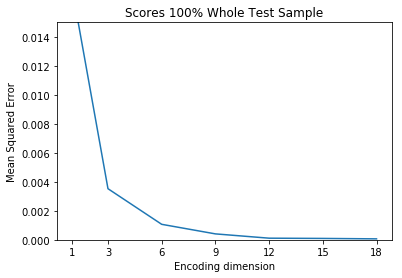

In [94]:
# Plotting the training loss (linear plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.plot(l_encoding_dim, l_score)
plt.title("Scores 100% Whole Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
#plt.ylim(0, max(l_score)*1.2)
plt.ylim(0, 0.015)
plt.savefig("./img/scores_{}.png".format(TYPE))

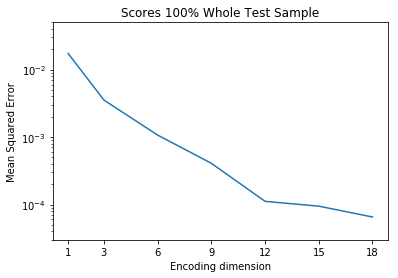

In [95]:
# Plotting the training loss (log plot)
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.semilogy(l_encoding_dim, l_score)
plt.title("Scores 100% Whole Test Sample")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.xticks(l_encoding_dim)
#plt.ylim(0, max(l_score)*1.2)
plt.ylim(0.00003, 0.05)
plt.savefig("./img/scores_log_{}.png".format(TYPE))

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Тестирование автоэнкодера на задаче классификации

In [96]:
# Save
def _transform_val(v):
    if isinstance(v, dict):
        return {kk: list(vv) if isinstance(vv, np.ndarray) else vv 
                for kk, vv in v.items()}
    elif isinstance(v, np.ndarray):
        return list(v)
    else:
        return v
    
def dump(saved_dict, folder, name):
    """ Save a 'saved_dict' to .json in 'folder' with 'name'.
    
    Params
    ------
        saved_dict : dict, {'encoding_dim' : [metric_value, ...]} or 
                           {'pid_label' : {'encoding_dim' : [metric_value, ...]} }
            Dict of a metric. 
    """
    dict_for_json = {k: _transform_val(v) for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json


def get_last_dir_n(path_to_metrics, metrics_dir_name):
    """ Return the highest number of folders which name == number"""
    try:
        last_folder_n = max(list(map(lambda name: int(name.split('_')[-1]), 
                                     filter(lambda name: os.path.isdir(os.path.join(path_to_metrics, name)) 
                                            and name.split('_')[-1].isdecimal(), os.listdir(path_to_metrics)))))
    except:
        last_folder_n = None
        
    return last_folder_n


def create_metrics_folder(path_to_metrics, metrics_dir_name):
    """ Create new folder for metrics in 'metrics_path' dir.
    Return
    ------
        new_folder : str
            Path to new folder.
        old_folder : str
            Path to prev folder.
    """
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    if last_folder_n is None:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_0')
        old_folder = None
    else:
        new_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n + 1))
        old_folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    os.makedirs(new_folder)
    
    return new_folder, old_folder


def dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict):
    """ Save all metrics from 'metrics_dict' to .json files.
        Save in 'path_to_metrics' + 'metrics_dir_name' + '_' + str(version) dir 
        to new folder and delete prev version.
        
    Params
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    folder, old_folder = create_metrics_folder(path_to_metrics, metrics_dir_name)
    print(folder)

    for metric_name, metric_values in metrics_dict.items():
        dump(metric_values, folder, metric_name)
    
    if old_folder is not None:
        shutil.rmtree(old_folder, ignore_errors=True)

In [97]:
# Load
def load_metrics(path_to_metrics, metrics_dir_name):
    """
    Return
    ------    
        metrics_dict : dict, {'metric_name' :  {'encoding_dim' : [metric_value, ...]}} or
                             {'metric_name' :  {'pid_label' : {'encoding_dim' : [metric_value, ...]} }}
            Dict of dicts for all metrics.
    """
    metrics_dict = {}
    last_folder_n = get_last_dir_n(path_to_metrics, metrics_dir_name)
    folder = os.path.join(path_to_metrics, metrics_dir_name + '_' + str(last_folder_n))
    for file_name in filter(lambda name: name.endswith('.json'), os.listdir(folder)):
        with open(os.path.join(folder, file_name), 'r') as file:
            metrics_dict[file_name[:-5]] = json.load(file)
    return metrics_dict

In [115]:
metrics_dict['fpr'].keys()

dict_keys(['orig', 1, 3, 6, 9, 12, 15])

In [116]:
len(metrics_dict['fpr'].keys())

7

In [ ]:
plt.plot()

In [121]:
def plot_metrics(metrics_dict, pid_label=0, xlim=(0, 1), ylim=(0, 1)):
    plt.figure(figsize=(15, 7))
    lw = 2
    l_colors= ['darkorange', 'blue', 'red', 'green', 'black', 'yellow', 'orange', 'coral']
    # ROC AUC
    plt.subplot(1, 2, 1)
    for i, encoding_dim in enumerate(metrics_dict['fpr'].keys()):
        plt.plot(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} ROC AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict['roc_auc'][encoding_dim][pid_label], 
                metrics_dict['f_measure'][encoding_dim], metrics_dict['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title("ROC AUC")
    plt.savefig("./img/ROC_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    
    # PR AUC
    plt.subplot(1, 2, 2)
    for i, encoding_dim in enumerate(metrics_dict['precision'].keys()):
        plt.plot(
            metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], 
            color=l_colors[i], lw=lw, 
            label="{} PR AUC {:.3}, F {:.3}, Acc {:.3}".format(
                encoding_dim, metrics_dict['pr_auc'][encoding_dim][pid_label], 
                metrics_dict['f_measure'][encoding_dim], metrics_dict['acc'][encoding_dim]
            )
        )
    plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc="lower left")
    plt.title("PR AUC")
    plt.savefig("./img/PR_{}_xlim_{}_ylim_{}.png".format(TYPE, xlim, ylim))
    plt.show()

In [99]:
le = LabelEncoder()
y = le.fit_transform(test_MC[:, 0])

In [100]:
test_input.shape, y.shape, test_MC.shape, test.shape

((981692, 34), (981692,), (981692, 1), (981692, 50))

In [101]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(test_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = test_input[idx_train_clf], test_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_dec_dict, X_test_dec_dict = {}, {}
for encoding_dim in l_encoding_dim:
    # Input None -> decoded None
    save_decoded_dict[encoding_dim][test_mask^True] = np.nan
    
    X_train_dec_dict[encoding_dim] = save_decoded_dict[encoding_dim][idx_train_clf]
    X_test_dec_dict[encoding_dim] = save_decoded_dict[encoding_dim][idx_test_clf]

In [146]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [147]:
path_to_metrics = './metrics/'
metrics_dir_name = 'whole_data__std_maxabs__4_layers__each_with_aux__equal_n_units__decoded_with_Nones'

In [149]:
clf_encoding_dim = ["orig"] + l_encoding_dim
n_repeats = np.ones_like(clf_encoding_dim, dtype=int)
n_evals_for_dim = np.zeros_like(clf_encoding_dim, dtype=int)

In [150]:
n_repeats, n_evals_for_dim

(array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0]))

Run time: 2722.30 sec
n_evals_for_dim:  [1 1 1 1 1 1 1 1]


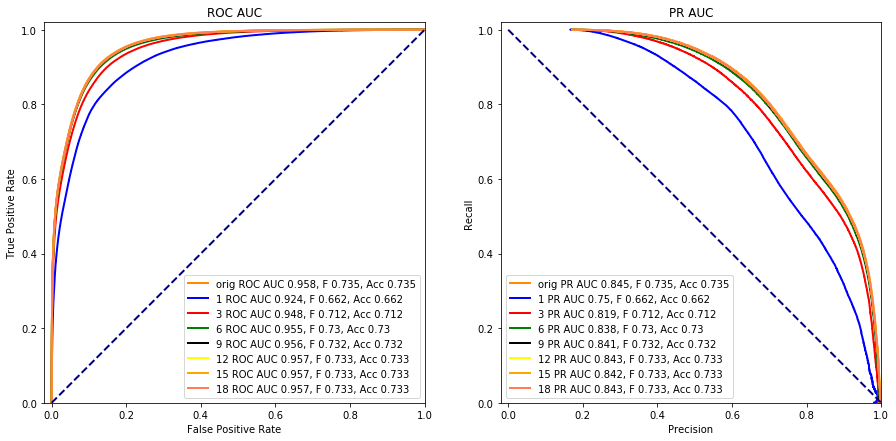

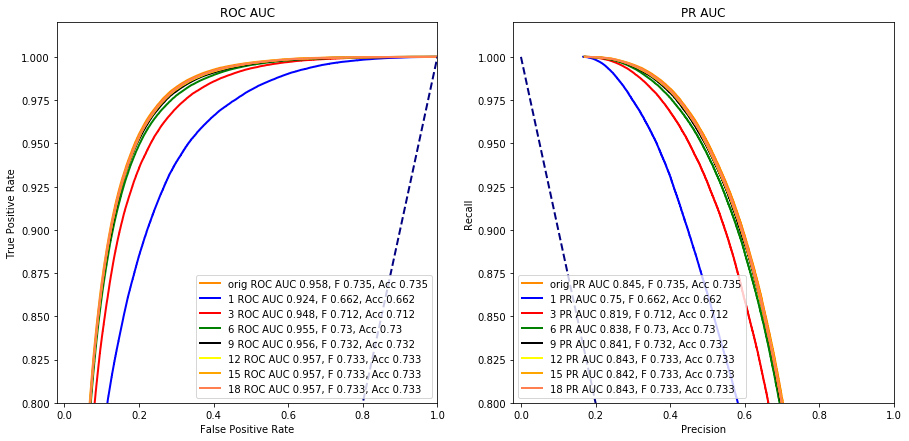

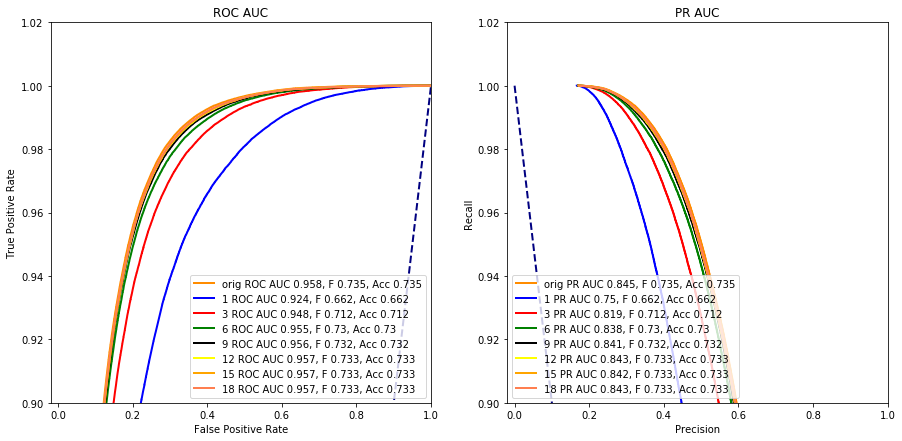

8it [6:01:50, 2769.28s/it]

CPU times: user 5h 58min 3s, sys: 7min 55s, total: 6h 5min 59s
Wall time: 6h 1min 50s


In [151]:
%%time
while np.sum(n_repeats - n_evals_for_dim) > 0:
    for i, encoding_dim in tqdm(enumerate(clf_encoding_dim)):
        if n_evals_for_dim[i] >= n_repeats[i]:
            continue
        clf = xgb.XGBClassifier(nthread=-1, seed=111)

        # fit model and predict probas
        start_time = timeit.default_timer()
        if encoding_dim == "orig":
            clf.fit(X_train, y_train)
            y_proba = clf.predict_proba(X_test)
        else:
            clf.fit(X_train_dec_dict[encoding_dim], y_train)
            y_proba = clf.predict_proba(X_test_dec_dict[encoding_dim])
        y_pred = np.argmax(y_proba, axis=1)
        y_bin = label_binarize(y_test, classes=np.unique(y_test))
        run_time = timeit.default_timer() - start_time

        # Compute ROC/PR curve and ROC/PR area for each class
        for pid_label in np.unique(y_test):
            idx = np.where(y_test == pid_label)[0]
            cur_y = np.where(y_test == pid_label, np.ones_like(y_test), np.zeros_like(y_test))
            cur_y_proba = y_proba[:, pid_label]

            pid_label = str(pid_label)
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
                roc_curve(cur_y, cur_y_proba)
            metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
                precision_recall_curve(cur_y, cur_y_proba)

        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
            roc_curve(y_bin.ravel(), y_proba.ravel())
        metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
            precision_recall_curve(y_bin.ravel(), y_proba.ravel())

        metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
            metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
        metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())

        metrics_dict['f_measure'][encoding_dim] = f1_score(y_test, y_pred, average='micro')
        metrics_dict['acc'][encoding_dim] = accuracy_score(y_test, y_pred)

        # Save
        dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
        n_evals_for_dim[i] += 1

        # Plot
        display.clear_output(wait=True)
        print("Run time: {:.2f} sec".format(run_time))
        print('n_evals_for_dim: ', n_evals_for_dim)
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))

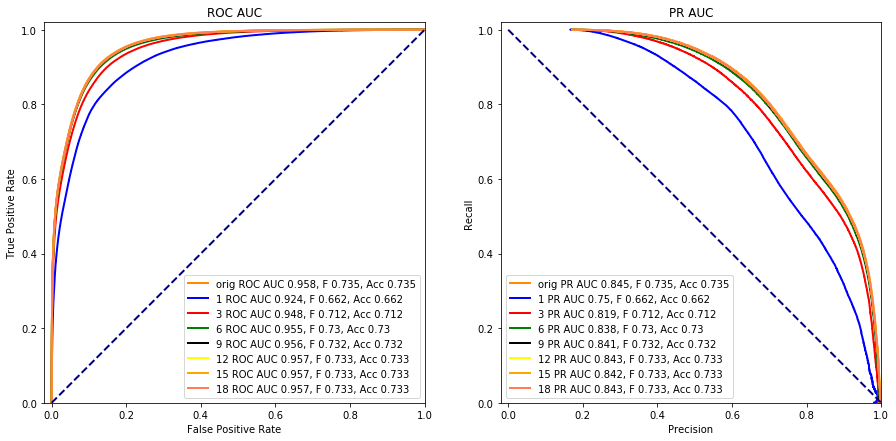

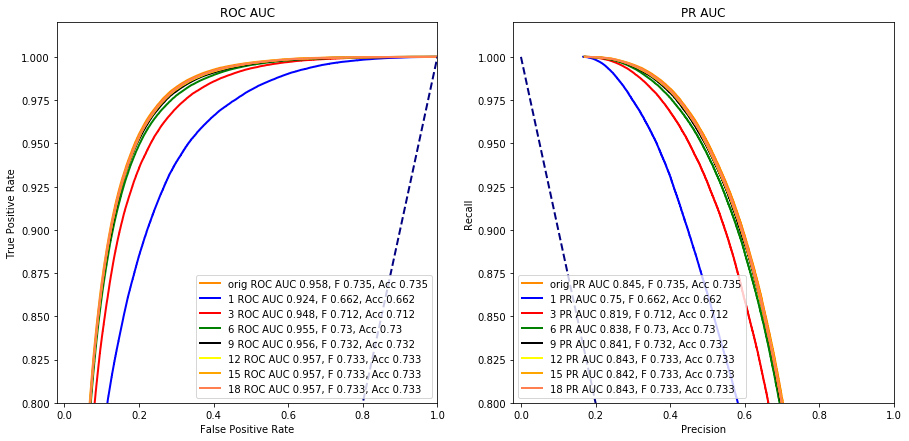

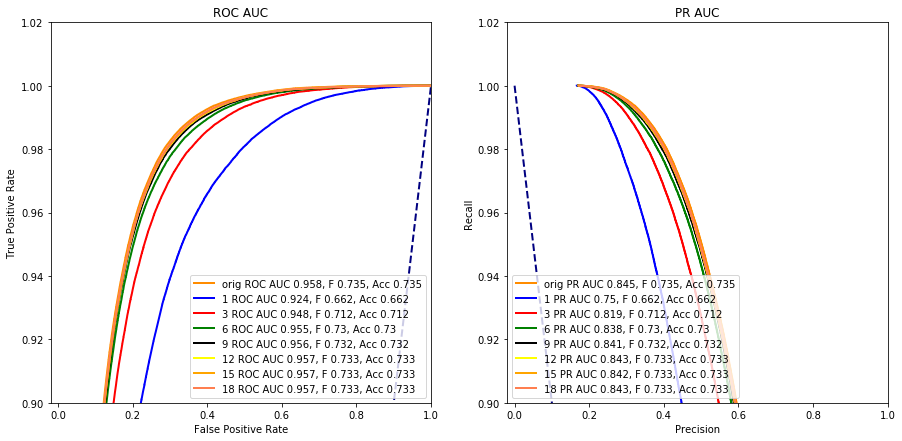

In [152]:
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))